<a href="https://colab.research.google.com/github/francis-jeon/Repository_francis/blob/main/anomaly_detection_minjong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##*Dataset* download via Kaggle API

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download podsyp/find-a-defect-in-the-production-extrusion-line

 89% 43.0M/48.5M [00:00<00:00, 59.5MB/s]
100% 48.5M/48.5M [00:00<00:00, 64.3MB/s]


#<strong> Machine Learning approach </strong>

##Import neccesary libraries / dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import os
import sys
import warnings
import seaborn as sns

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
import zipfile 
dataset_path = "/content/find-a-defect-in-the-production-extrusion-line.zip"
zfile = zipfile.ZipFile(dataset_path)
zfile.extractall()

In [4]:
data = pd.read_csv('/content/extrusion.csv')

data.head()

,Datum,ST0_VARActAuftrag,ST110_VARExtr_0_HeizungZone_3_Regler_Y,ST110_VARExtr_0_HeizungZone_3_SollTemp,ST110_VARExtr_0_HeizungZone_4_Konfig,ST110_VARExtr_0_HeizungZone_4_Regler_X,ST110_VARExtr_0_HeizungZone_4_Regler_Y,ST110_VARExtr_0_HeizungZone_4_SollTemp,ST110_VARExtr_0_HeizungZone_5_Konfig,ST110_VARExtr_0_HeizungZone_5_Regler_X,...,ST114_VARTensPlusSp,ST114_VARTotalLen,ST114_VARTotalRolls,ST114_VARWdCloseCmd,ST114_VARWdSpeedHMI,ST114_VARWdSpSpeed,ST114_VARWdSpTens,ST114_VARWdTapeNum,ST114_VARWdTapeReductVal,ST114_VARWdTensVis
0,25.06.2018 4:40,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,21.0,3544103.0,2174.0,1.0,78.0,0.0,50.0,5.0,15.0,53.0
1,25.06.2018 4:42,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,21.0,3544103.0,2174.0,1.0,81.0,0.0,50.0,5.0,15.0,49.0
2,25.06.2018 4:45,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,21.0,3544103.0,2174.0,1.0,81.0,0.0,50.0,5.0,15.0,48.0
3,25.06.2018 4:47,0.0,10.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,21.0,3544103.0,2174.0,1.0,81.0,0.0,50.0,5.0,15.0,50.0
4,25.06.2018 4:49,0.0,11.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,21.0,3544103.0,2174.0,1.0,81.0,0.0,50.0,5.0,15.0,51.0


In [5]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                                      df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
data = reduce_mem_usage(data)

Memory usage of dataframe is 812.32 MB
Memory usage after optimization is: 217.62 MB
Decreased by 73.2%


##Preprocessing Steps 1: Checking Null Values

In [7]:
Sum = data.isnull().sum().sort_values(ascending=False)
percent = ((data.isnull().sum()/data.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([Sum, percent], axis=1, keys=['Sum', 'Percent'])
missing_data

,Sum,Percent
ST114_VARWdTensVis,1101,0.486015
ST114_VARLmpRun,1101,0.486015
ST114_VARGesamtZeit,1101,0.486015
ST114_VARGapMin,1101,0.486015
ST114_VARGapMax,1101,0.486015
...,...,...
ST110_VARExtr_3_HeizungZone_8_Regler_Y,62,0.027369
ST110_VARExtr_3_HeizungZone_8_Regler_X,62,0.027369
ST110_VARExtr_0_HeizungZone_3_SollTemp,62,0.027369
ST0_VARActAuftrag,0,0.000000


In [8]:
data['Datum'] = pd.to_datetime(data['Datum']).dt.date
data.head()

,Datum,ST0_VARActAuftrag,ST110_VARExtr_0_HeizungZone_3_Regler_Y,ST110_VARExtr_0_HeizungZone_3_SollTemp,ST110_VARExtr_0_HeizungZone_4_Konfig,ST110_VARExtr_0_HeizungZone_4_Regler_X,ST110_VARExtr_0_HeizungZone_4_Regler_Y,ST110_VARExtr_0_HeizungZone_4_SollTemp,ST110_VARExtr_0_HeizungZone_5_Konfig,ST110_VARExtr_0_HeizungZone_5_Regler_X,...,ST114_VARTensPlusSp,ST114_VARTotalLen,ST114_VARTotalRolls,ST114_VARWdCloseCmd,ST114_VARWdSpeedHMI,ST114_VARWdSpSpeed,ST114_VARWdSpTens,ST114_VARWdTapeNum,ST114_VARWdTapeReductVal,ST114_VARWdTensVis
0,2018-06-25,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,21.0,3544103.0,2174.0,1.0,78.0,0.0,50.0,5.0,15.0,53.0
1,2018-06-25,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,21.0,3544103.0,2174.0,1.0,81.0,0.0,50.0,5.0,15.0,49.0
2,2018-06-25,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,21.0,3544103.0,2174.0,1.0,81.0,0.0,50.0,5.0,15.0,48.0
3,2018-06-25,0.0,10.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,21.0,3544103.0,2174.0,1.0,81.0,0.0,50.0,5.0,15.0,50.0
4,2018-06-25,0.0,11.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,21.0,3544103.0,2174.0,1.0,81.0,0.0,50.0,5.0,15.0,51.0


In [9]:
from datetime import datetime

data['year'] = pd.to_datetime(data['Datum']).dt.strftime('%Y')
data['month'] = pd.DatetimeIndex(data['Datum']).month
data['date'] = pd.to_datetime(data['Datum']).dt.strftime('%d')

data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

,Datum,ST0_VARActAuftrag,ST110_VARExtr_0_HeizungZone_3_Regler_Y,ST110_VARExtr_0_HeizungZone_3_SollTemp,ST110_VARExtr_0_HeizungZone_4_Konfig,ST110_VARExtr_0_HeizungZone_4_Regler_X,ST110_VARExtr_0_HeizungZone_4_Regler_Y,ST110_VARExtr_0_HeizungZone_4_SollTemp,ST110_VARExtr_0_HeizungZone_5_Konfig,ST110_VARExtr_0_HeizungZone_5_Regler_X,...,ST114_VARWdCloseCmd,ST114_VARWdSpeedHMI,ST114_VARWdSpSpeed,ST114_VARWdSpTens,ST114_VARWdTapeNum,ST114_VARWdTapeReductVal,ST114_VARWdTensVis,year,month,date
0,2018-06-25,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,1.0,78.0,0.0,50.0,5.0,15.0,53.0,2018,6,25
1,2018-06-25,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,1.0,81.0,0.0,50.0,5.0,15.0,49.0,2018,6,25
2,2018-06-25,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,1.0,81.0,0.0,50.0,5.0,15.0,48.0,2018,6,25
3,2018-06-25,0.0,10.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,1.0,81.0,0.0,50.0,5.0,15.0,50.0,2018,6,25
4,2018-06-25,0.0,11.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,1.0,81.0,0.0,50.0,5.0,15.0,51.0,2018,6,25


##Preprocessing Steps 2: Determining target variable

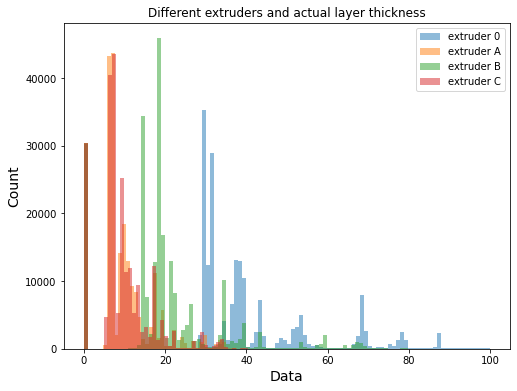

In [10]:
plt.figure(figsize=(8,6))
plt.hist(data[data['ST110_VAREx_0_SDickeIst'] < 100]['ST110_VAREx_0_SDickeIst'], bins=100, alpha=0.5, label="extruder 0")
plt.hist(data[data['ST110_VAREx_1_SDickeIst'] < 100]['ST110_VAREx_1_SDickeIst'], bins=100, alpha=0.5, label="extruder A")
plt.hist(data[data['ST110_VAREx_2_SDickeIst'] < 100]['ST110_VAREx_2_SDickeIst'], bins=100, alpha=0.5, label="extruder B")
plt.hist(data[data['ST110_VAREx_3_SDickeIst'] < 100]['ST110_VAREx_3_SDickeIst'], bins=100, alpha=0.5, label="extruder C")
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Different extruders and actual layer thickness")
plt.legend(loc='upper right')

In [12]:
data['EXT0'] = data['ST110_VAREx_0_SDickeIst'].apply(lambda x: 1 if x == 0 else 0)
data['EXTA'] = data['ST110_VAREx_1_SDickeIst'].apply(lambda x: 1 if x == 0 else 0)
data['EXTB'] = data['ST110_VAREx_2_SDickeIst'].apply(lambda x: 1 if x == 0 else 0)
data['EXTC'] = data['ST110_VAREx_3_SDickeIst'].apply(lambda x: 1 if x == 0 else 0)
data['EXTsum'] = data['EXTC']+data['EXTA']+data['EXTB']+data['EXT0']
data['EXTtotal'] = data['EXTsum'].apply(lambda x: 0 if x == 0 else 1)

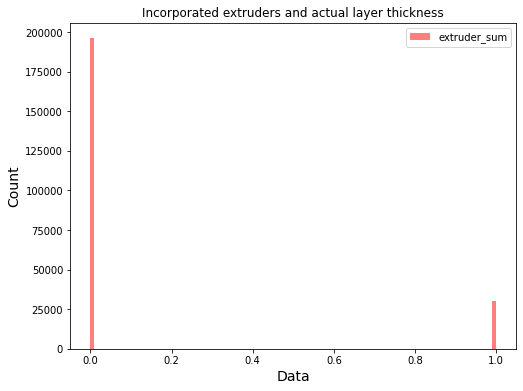

In [13]:
plt.figure(figsize=(8,6))
plt.hist(data[data['EXTtotal'] < 100]['EXTtotal'], bins=100, alpha=0.5, label="extruder_sum", color='r')
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Incorporated extruders and actual layer thickness")
plt.legend(loc='upper right')

In [14]:
data['EXTtotal'].value_counts()

0    196068
1     30468
Name: EXTtotal, dtype: int64

##Preprocessing Steps 3: 

* Delete unneccessary columns and drop N/A

* Find categoricla columns -> if exist, should be converted via One-Hot encoding or Label encoding






---



In [15]:
data = data.drop(['Datum'], axis=1)
data.head()

,ST0_VARActAuftrag,ST110_VARExtr_0_HeizungZone_3_Regler_Y,ST110_VARExtr_0_HeizungZone_3_SollTemp,ST110_VARExtr_0_HeizungZone_4_Konfig,ST110_VARExtr_0_HeizungZone_4_Regler_X,ST110_VARExtr_0_HeizungZone_4_Regler_Y,ST110_VARExtr_0_HeizungZone_4_SollTemp,ST110_VARExtr_0_HeizungZone_5_Konfig,ST110_VARExtr_0_HeizungZone_5_Regler_X,ST110_VARExtr_0_HeizungZone_5_Regler_Y,...,ST114_VARWdTensVis,year,month,date,EXT0,EXTA,EXTB,EXTC,EXTsum,EXTtotal
0,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,22.0,...,53.0,2018,6,25,0,0,0,0,0,0
1,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,23.0,...,49.0,2018,6,25,0,0,0,0,0,0
2,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,22.0,...,48.0,2018,6,25,0,0,0,0,0,0
3,0.0,10.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,23.0,...,50.0,2018,6,25,0,0,0,0,0,0
4,0.0,11.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,23.0,...,51.0,2018,6,25,0,0,0,0,0,0


In [16]:
data = data.drop(['EXT0', 'EXTA', 'EXTB', 'EXTC', 'EXTsum', 'ST110_VAREx_0_SDickeIst', 'ST110_VAREx_1_SDickeIst', 'ST110_VAREx_2_SDickeIst', 'ST110_VAREx_3_SDickeIst'], axis = 1)
data = data.dropna()
data.isnull().sum().sum()

0

In [17]:
objList = data.select_dtypes(include = "object").columns
print(objList)

Index(['year', 'date'], dtype='object')


##Preprocessing Steps 4: Simple EDA on target variable



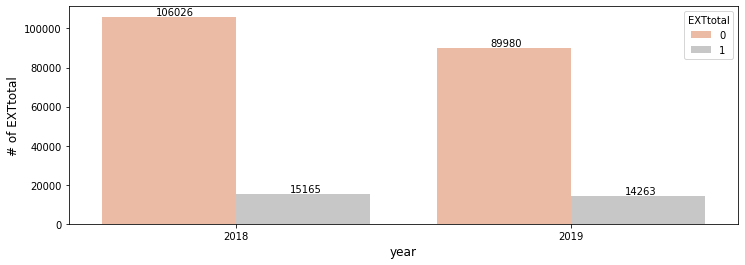

In [18]:
plt.figure(figsize=(12,4))

ax = sns.countplot(data = data, x = 'year', hue="EXTtotal", palette = 'RdGy')

plt.xlabel("year", fontsize= 12)
plt.ylabel("# of EXTtotal", fontsize= 12)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.16, p.get_height()+1000))

plt.show()

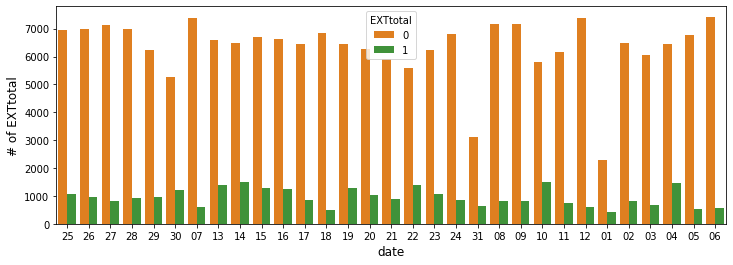

In [19]:
plt.figure(figsize=(12,4))

ax = sns.countplot(data = data, x = 'date', hue="EXTtotal", palette = 'Paired_r')

plt.xlabel("date", fontsize= 12)
plt.ylabel("# of EXTtotal", fontsize= 12)



plt.show()

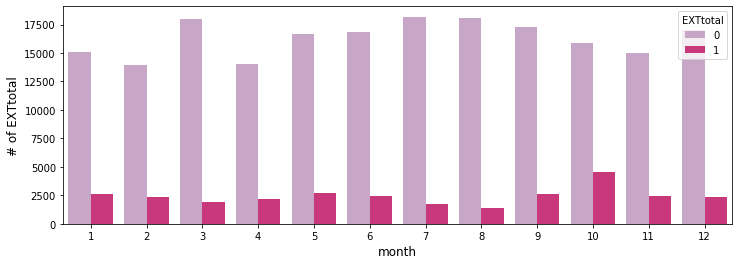

In [20]:
plt.figure(figsize=(12,4))

ax = sns.countplot(data = data, x = 'month', hue="EXTtotal", palette = 'PuRd')

plt.xlabel("month", fontsize= 12)
plt.ylabel("# of EXTtotal", fontsize= 12)



plt.show()

In [21]:
corr_matrix = data.corr().abs()
cor_target = corr_matrix["EXTtotal"]

In [22]:
relevant_features = cor_target[cor_target>0.]
relevant_features

ST110_VARExtr_0_HeizungZone_3_Regler_Y    0.426451
ST110_VARExtr_0_HeizungZone_3_SollTemp    0.350227
ST110_VARExtr_0_HeizungZone_4_Regler_X    0.447943
ST110_VARExtr_0_HeizungZone_4_Regler_Y    0.318290
ST110_VARExtr_0_HeizungZone_4_SollTemp    0.352378
                                            ...   
ST114_VARWdSpeedHMI                       0.692658
ST114_VARWdSpTens                         0.005695
ST114_VARWdTensVis                        0.627557
month                                     0.013047
EXTtotal                                  1.000000
Name: EXTtotal, Length: 350, dtype: float64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


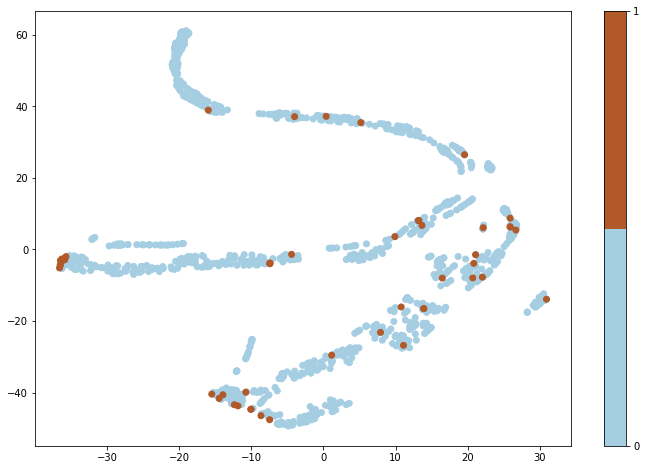

In [23]:
from sklearn.manifold import TSNE

data_tsne=data[data['EXTtotal']==0].sample(1000)
data_tsne_abnormal=data[data['EXTtotal']==1].sample(50)
data_tsne=pd.concat([data_tsne,data_tsne_abnormal])
y_plt=data_tsne['EXTtotal']
X_plt=data_tsne.drop('EXTtotal',1)

X_embedded = TSNE(n_components=2).fit_transform(X_plt)

plt.figure(figsize=(12,8))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_plt, cmap=plt.cm.get_cmap("Paired", 2))
plt.colorbar(ticks=range(2))

In [24]:
pred = data.drop(['EXTtotal'], axis=1)
target = data['EXTtotal']

##Preprocessing Steps 5: PCA since more than 400 columns exist

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler().fit(pred)
pred=scaler.transform(pred)

pca=PCA(n_components=5)
principalComponents=pca.fit_transform(pred)
pca_result=pd.DataFrame(data= principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5'])

In [26]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[76.94605015 38.59136111 28.71586398 14.03895491 11.71368275]
[0.21921854 0.10994641 0.08181122 0.03999685 0.03337217]
[0.21921854 0.32916495 0.41097617 0.45097301 0.48434518]


In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca_result = pca.fit_transform(pred)
pca_result = pd.DataFrame(pca_result)
pca_result.head()

,0,1,2,3,4
0,-5.227052,7.199301,4.228665,-2.544303,-3.964058
1,-5.217645,7.063703,3.918170,-2.699682,-4.014281
2,-5.212943,7.194251,4.118350,-2.616951,-3.953944
3,-5.301629,7.182970,3.894066,-2.614762,-3.927165
4,-5.322019,7.185694,3.918251,-2.612281,-3.912631


##Preprocessing Steps 6: Train test split for machine learning approach

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(pca_result, target, test_size=0.2, random_state=77, stratify=target)

##Various machine learning classifiers

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.metrics import classification_report, accuracy_score

In [32]:
estimators = {
    'KNN':KNeighborsClassifier(),
    'Logistic Regression':LogisticRegression(),
    'XGBoost':XGBClassifier(),
    'LGBM': LGBMClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Extra Tree': ExtraTreeClassifier()
}

In [33]:
for name, clf in estimators.items():
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    n_errors = (pred != y_test).sum()

    print("{}: {}".format(name,n_errors))
    print(classification_report(y_test, pred))
    print('-'*50)

KNN: 124
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39201
           1       0.99      0.99      0.99      5886

    accuracy                           1.00     45087
   macro avg       0.99      1.00      0.99     45087
weighted avg       1.00      1.00      1.00     45087

--------------------------------------------------
Logistic Regression: 168
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39201
           1       0.98      0.99      0.99      5886

    accuracy                           1.00     45087
   macro avg       0.99      0.99      0.99     45087
weighted avg       1.00      1.00      1.00     45087

--------------------------------------------------
XGBoost: 162
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39201
           1       0.98      0.99      0.99      5886

    accuracy                     

# Anomaly detection algorithms: Isolation Forest, Local Outlier, One Class SVM: 

##Define abnormal_proportion for those algorithms 

In [29]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM


abnormal = target[target == 1]
normal = target[target == 0]

abnormal_proportion = len(abnormal) / float(len(normal))

abnormal_proportion

0.15013826107364062

##Local Outlier Factor

In [34]:
lof = LocalOutlierFactor(contamination=abnormal_proportion)
lof.fit(X_test)

lof_y_pred=lof.negative_outlier_factor_

lof_y_pred_class=lof_y_pred.copy()
lof_y_pred_class[lof_y_pred>=np.percentile(lof_y_pred,85)]=1
lof_y_pred_class[lof_y_pred<np.percentile(lof_y_pred,85)]=0
n_errors = (lof_y_pred_class != y_test).sum()


print(classification_report(y_test, lof_y_pred_class))
print(n_errors)

              precision    recall  f1-score   support

           0       0.86      0.84      0.85     39201
           1       0.09      0.10      0.09      5886

    accuracy                           0.75     45087
   macro avg       0.47      0.47      0.47     45087
weighted avg       0.76      0.75      0.75     45087

11487


##Isolation Forest

In [ ]:
def get_pred_label(model_pred):
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

In [ ]:
ift = IsolationForest(max_samples=len(pred), contamination=abnormal_proportion,random_state=77, verbose=0)
ift.fit(X_train, y_train)

y_pred = ift.predict(X_test) 
y_pred = get_pred_label(y_pred)

n_errors = (y_pred != y_test).sum()

print(classification_report(y_test, y_pred))
print(n_errors)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     39201
           1       0.43      0.49      0.46      5886

    accuracy                           0.85     45087
   macro avg       0.67      0.70      0.68     45087
weighted avg       0.86      0.85      0.85     45087

5886
